In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import os
path = "/home/piotr/projects/twitter"
gov = pickle.load(open(os.path.join(path, "data/sample/gov_sample.pickle"),"rb"))
opp = pickle.load(open(os.path.join(path, "data/sample/opp_sample.pickle"),"rb"))
from tqdm.notebook import tqdm
from collections import defaultdict
import sys
sys.path.append(os.path.join(path, "src"))
from twitter_tools.utils import check_errors

In [5]:
def count_connections(path, **kwargs):
    connections = defaultdict(lambda: defaultdict(lambda: 0)) #counts of 
    for data in tqdm(pd.read_csv(path, iterator = True, **kwargs)):
        
        #check data integrity and drop problematic ids
        data = check_errors(data)
        
        #keep useful columns
        cols = [elem for elem in data.columns if 'user' in elem and 'id_str' in elem] #columns marking user connections
        data = data[cols + ["created_at"]] #keep these + date
        
        #convert date
        data.loc[:,("created_at")] = pd.to_datetime(data["created_at"], 
                                       format = "%a %b %d %H:%M:%S +0000 %Y").dt.date.astype(str)
            
        #get columns of interest:
        cols_connections = [x for x in cols if x != "user-id_str"]
        
        
        #government links:
        cols_gov_connections = [x + "_gov" for x in cols_connections]
        data[cols_gov_connections] = data[cols_connections].apply(lambda x: x.isin(gov))
        data['sum_gov'] = data[[col for col in data.columns if 'gov' in col]].sum(axis = 1)

        #opp links:
        cols_opp_connections = [x + "_opp" for x in cols_connections]
        data[cols_opp_connections] = data[cols_connections].apply(lambda x: x.isin(opp))
        data['sum_opp'] = data[[col for col in data.columns if 'opp' in col]].sum(axis = 1)

        
        #get sums in each connection category
        data['total'] = 1 #this represent the total number of TWEETS on a given day
        data = data.groupby(["created_at", "user-id_str"]).sum().to_dict()
        for k, v in data.items():
            for (date, id), count in v.items():
                connections[k][(date, id)] += count
                
    connections = dict({k:dict(v) for k, v in connections.items()})
    return connections

In [6]:
path_file = os.path.join(path, "data/connections.p")
if os.path.isfile(path_file):
    connections = pickle.load(open(path_file, "rb"))
else:
    opp_connections = count_connections(os.path.join(path, "data/scraped/opp_tweets.csv"), chunksize = 100000, dtype = str)
    gov_connections = count_connections(os.path.join(path, "data/scraped/gov_tweets.csv"), chunksize = 100000, dtype = str)
    connections = dict().fromkeys(opp_connections.keys())
    for key in connections:
        connections[key] = gov_connections[key].copy()
        connections[key].update(opp_connections[key].copy())
    print(len(opp_connections['in_reply_to_user_id_str_gov']))
    print(len(gov_connections['in_reply_to_user_id_str_gov']))
    print(len(connections['in_reply_to_user_id_str_gov']))
    pickle.dump(connections, open(path_file, "wb"))

In [7]:
connections = pd.DataFrame(connections)
connections.index.names = ['day','user-id_str']
connections['source'] = np.where(connections.reset_index()['user-id_str'].astype(str).isin(gov), 'gov', 'opp')

In [22]:
aggregated = connections.groupby(['day','source']).sum()
aggregated = aggregated.apply(lambda x: x/aggregated.total) #normalize
aggregated.reset_index(inplace = True)
aggregated = aggregated[aggregated.day != '2020-05-16']

### Total interactions between partisans and their own network vs the opposing party's network

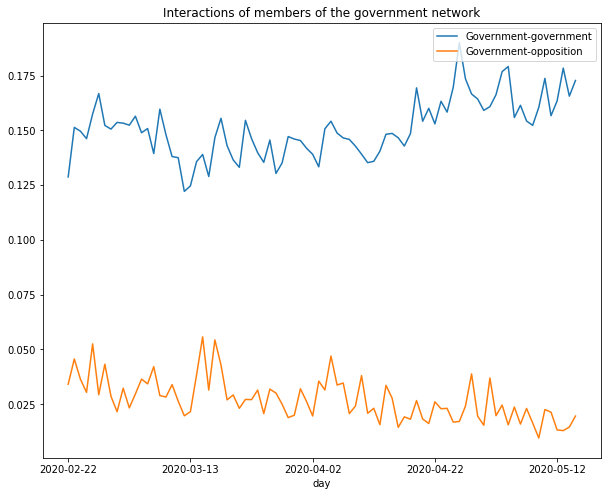

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'gov'].plot('day' ,'sum_gov', ax = ax)
aggregated[aggregated.source == 'gov'].plot('day' ,'sum_opp', ax = ax)
plt.legend(['Government-government', 'Government-opposition'], loc = 'upper right')
plt.title('Interactions of members of the government network')
plt.show()

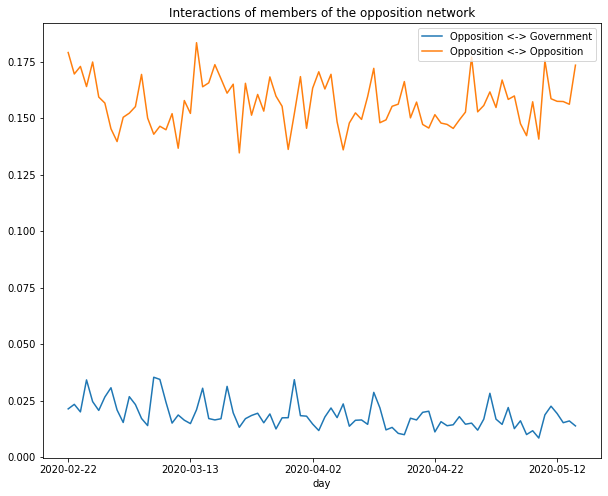

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'opp'].plot('day' ,'sum_gov', ax = ax)
aggregated[aggregated.source == 'opp'].plot('day' ,'sum_opp', ax = ax)
plt.legend(['Opposition <-> Government', 'Opposition <-> Opposition'], loc = 'upper right')
plt.title('Interactions of members of the opposition network')
plt.show()

### Retweets between partisans and their own network vs the opposing party's network

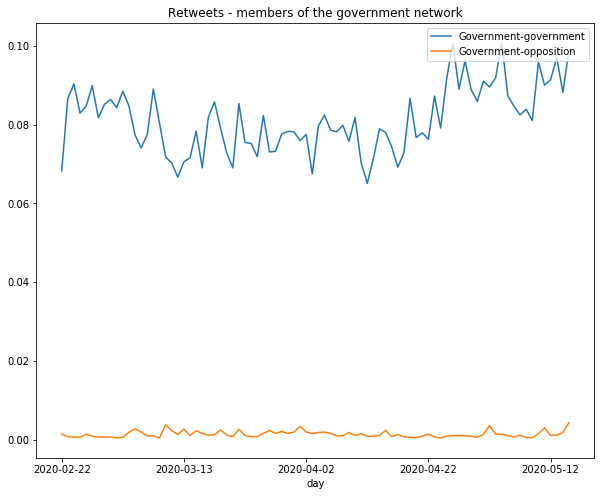

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'gov'].plot('day' ,'retweeted_status-user-id_str_gov', ax = ax)
aggregated[aggregated.source == 'gov'].plot('day' ,'retweeted_status-user-id_str_opp', ax = ax)
plt.legend(['Government-government', 'Government-opposition'], loc = 'upper right')
plt.title('Retweets - members of the government network')
plt.show()

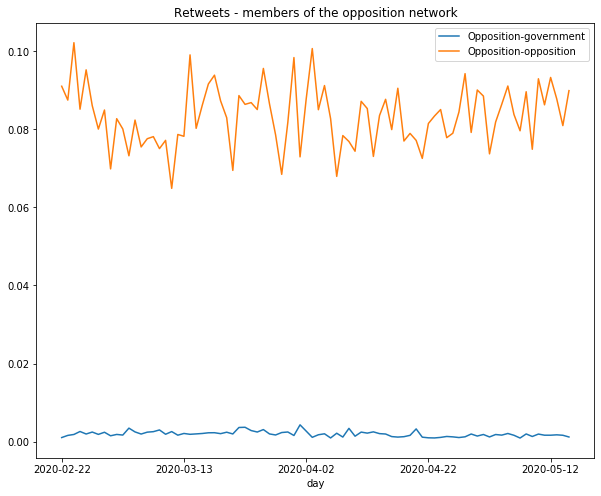

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'opp'].plot('day' ,'retweeted_status-user-id_str_gov', ax = ax)
aggregated[aggregated.source == 'opp'].plot('day' ,'retweeted_status-user-id_str_opp', ax = ax)
plt.legend(['Opposition-government', 'Opposition-opposition'], loc = 'upper right')
plt.title('Retweets - members of the opposition network')
plt.show()

### Replies between partisans and their own network vs the opposing party's network

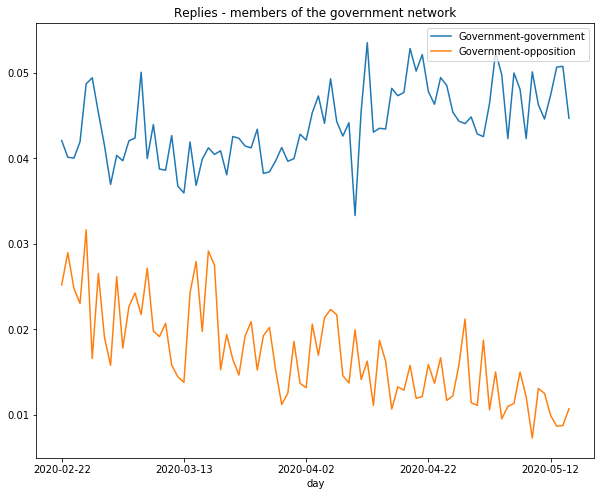

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'gov'].plot('day' ,'in_reply_to_user_id_str_gov', ax = ax)
aggregated[aggregated.source == 'gov'].plot('day' ,'in_reply_to_user_id_str_opp', ax = ax)
plt.legend(['Government-government', 'Government-opposition'], loc = 'upper right')
plt.title('Replies - members of the government network')
plt.show()

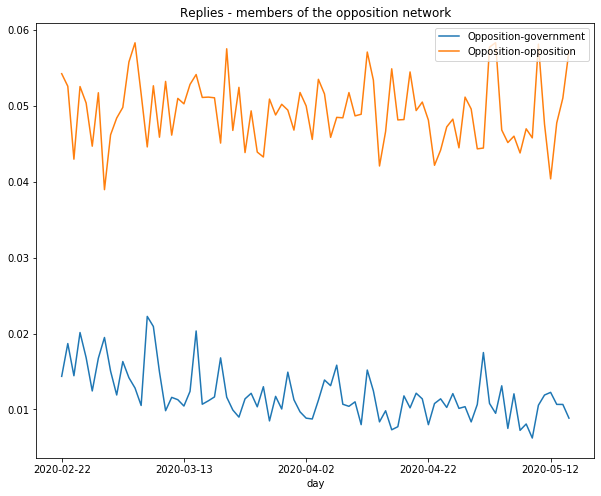

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
aggregated[aggregated.source == 'opp'].plot('day' ,'in_reply_to_user_id_str_gov', ax = ax)
aggregated[aggregated.source == 'opp'].plot('day' ,'in_reply_to_user_id_str_opp', ax = ax)
plt.legend(['Opposition-government', 'Opposition-opposition'], loc = 'upper right')
plt.title('Replies - members of the opposition network')
plt.show()